size onlyfiles:  1
shape of image begin:  (176, 208, 176)


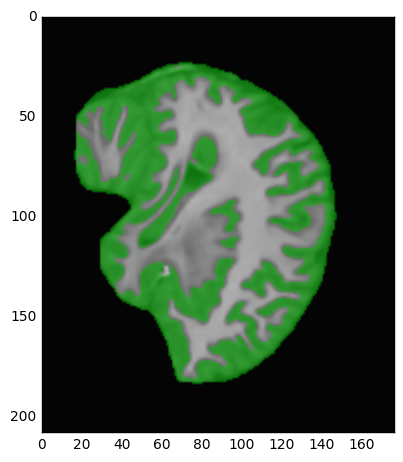

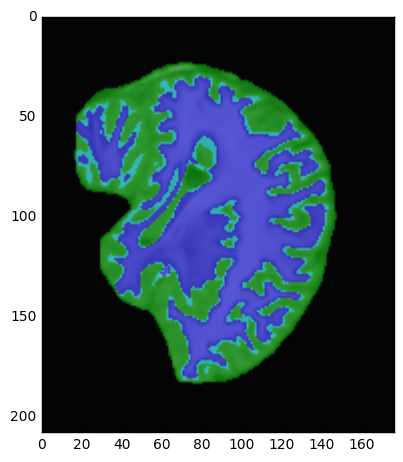

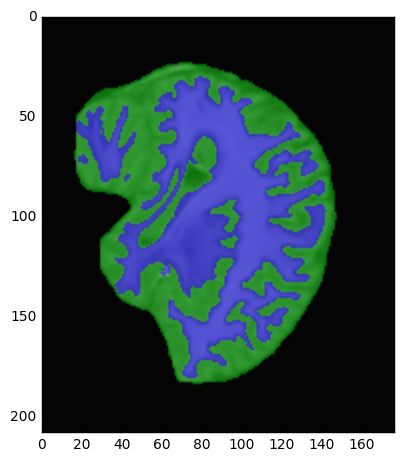

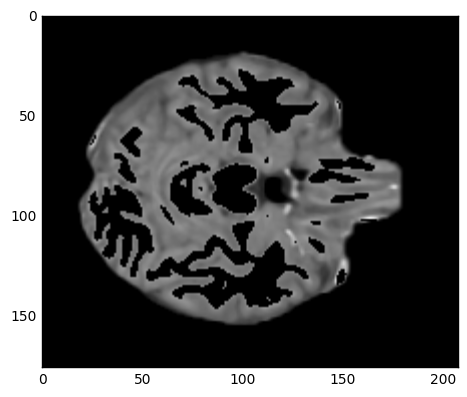

old shape: 
shape[0]:  176
shape[1]:  208
shape[2]:  176
shape of image end:  (1, 6443008)
endImg saved to:  /home/dinesh/Desktop/ML16/Project1/Images/set_train_gray_matter_maps/train_1.nii


In [2]:
import os
import numpy as np
import gc
import SimpleITK
import nibabel as nib
import matplotlib.pyplot as plt
from scipy import sparse, io
#%pylab inline

# all images have identical boundaries (checked)
rmin = 18
rmax = 154
cmin = 18
cmax = 188
zmin = 7
zmax = 151
offset = 0

mode = 'train'

# help function for visulazing
def sitk_show(img, title=None, margin=0.05, dpi=40 ):
    nda = SimpleITK.GetArrayFromImage(img)
    spacing = img.GetSpacing()
    figsize = (1 + margin) * nda.shape[0] / dpi, (1 + margin) * nda.shape[1] / dpi
    extent = (0, nda.shape[1]*spacing[1], nda.shape[0]*spacing[0], 0)
    fig = plt.figure(figsize=figsize, dpi=dpi)
    ax = fig.add_axes([margin, margin, 1 - 2*margin, 1 - 2*margin])

    plt.set_cmap("gray")
    ax.imshow(nda,extent=extent,interpolation=None)
    
    if title:
        plt.title(title)
    
    plt.show()
    
def nda_show(nda, title=None, margin=0.05, dpi=40 ):
    figsize = (1 + margin) * nda.shape[0] / dpi, (1 + margin) * nda.shape[1] / dpi
    fig = plt.figure(figsize=figsize, dpi=dpi)
    ax = fig.add_axes([margin, margin, 1 - 2*margin, 1 - 2*margin])

    plt.set_cmap("gray")
    ax.imshow(nda,interpolation=None)
    
    if title:
        plt.title(title)
    
    plt.show()    


#parent_data_folder = ''
#import getpass
#user = getpass.getuser()
#if user == 'igor':
#    parent_data_folder = '/home/dinesh/Desktop/ML16/Project1/Images/data_1/'
#elif user == 'pesici':
#    parent_data_folder = os.environ['HOME'] + '/'
# Directory where the DICOM files are being stored (in this
# case the 'MyHead' folder). 
pathData = '/home/dinesh/Desktop/ML16/Project1/Images/'+'set_'+mode+'/'
pathOutput = '/home/dinesh/Desktop/ML16/Project1/Images/'+'set_'+mode+'_gray_matter_maps/'

# Z slice of the DICOM files to process. In the interest of
# simplicity, segmentation will be limited to a single 2D
# image but all processes are entirely applicable to the 3D image
idxSlice = 55

# int labels to assign to the segmented white and gray matter.
# These need to be different integers but their values themselves
# don't matter
labelWhiteMatter = 2
labelGrayMatter = 1

from os.path import isfile, join
#onlyfiles = [f for f in os.listdir(pathData) if isfile(join(pathData, f)) and f.endswith('.nii')]
onlyfiles = [f for f in os.listdir(pathData) if isfile(join(pathData, f)) and f.endswith('_1.nii')]

print 'size onlyfiles: ', len(onlyfiles)
#itkImages = []
# to this only for part of images athe time
for f in onlyfiles:
    full_f = join(pathData, f)
    ndImg = nib.load(full_f).get_data()
    ndImg = np.sum(ndImg, axis=3)       # sum upon the 4th axis so that we reduce the img to 3d
    print 'shape of image begin: ', ndImg.shape
    itkImg = SimpleITK.GetImageFromArray(ndImg)
    
    #itkImages.append(itkImg)
    visImg = itkImg[:,:,idxSlice]
    #sitk_show(visImg)
    
    # Smmoth the image (because it is noisy now)
    # https://itk.org/SimpleITKDoxygen/html/classitk_1_1simple_1_1CurvatureFlowImageFilter.html#details
    imgSmooth = SimpleITK.CurvatureFlow(image1=itkImg,
                                    timeStep=0.125,
                                    numberOfIterations=5)
    visImg = imgSmooth[:,:,idxSlice]
    
    #ndaVis = SimpleITK.GetArrayFromImage(visImg)
    #print 'intensity mean: ', np.mean(ndaVis[np.nonzero(ndaVis)])
    #print 'intensity std: ', np.std(ndaVis[np.nonzero(ndaVis)])
    #print 'intensity NZ: ', np.count_nonzero(ndaVis) / (ndaVis.shape[0]* ndaVis.shape[1])
    #print 'intensity min: ', np.min(ndaVis[np.nonzero(ndaVis)])
    #print 'intensity max: ', np.max(ndaVis)
    
    #for i in range(ndaVis.shape[0]):
    #    for j in range(ndaVis.shape[1]):
    #        if ndaVis[i][j] < 840:
    #            ndaVis[i][j] = 0
    
    
    #nda_show(ndaVis)
    # Segmentation with the ConnectedThreshold filter
    white_lstSeeds = [(100,75,55)]
    #visImg[118,137] = -25
    #print 'vis seed value: ', visImg[118,137]
    #sitk_show(visImg)
    imgWhiteMatter = SimpleITK.ConnectedThreshold(image1=imgSmooth, 
                                            seedList=white_lstSeeds, 
                                            lower=840, 
                                            upper=1500,
                                            replaceValue=labelWhiteMatter)
    
    # Rescale 'imgSmooth' and cast it to an integer type to match that of 'imgWhiteMatter'
    imgSmoothInt = SimpleITK.Cast(SimpleITK.RescaleIntensity(imgSmooth), imgWhiteMatter.GetPixelID())

    # Use 'LabelOverlay' to overlay 'imgSmooth' and 'imgWhiteMatter'
    #sitk_show(SimpleITK.LabelOverlay(imgSmoothInt[:,:,idxSlice], imgWhiteMatter[:,:,idxSlice]))
    
    imgWhiteMatterNoHoles = SimpleITK.VotingBinaryHoleFilling(image1=imgWhiteMatter,
                                                          radius=[2]*3,
                                                          majorityThreshold=1,
                                                          backgroundValue=0,
                                                          foregroundValue=labelWhiteMatter)
    
    # Rescale 'imgSmooth' and cast it to an integer type to match that of 'imgWhiteMatter'
    imgSmoothInt = SimpleITK.Cast(SimpleITK.RescaleIntensity(imgSmooth), imgWhiteMatterNoHoles.GetPixelID())

    # Use 'LabelOverlay' to overlay 'imgSmooth' and 'imgWhiteMatter'
    #sitk_show(SimpleITK.LabelOverlay(imgSmoothInt[:,:,idxSlice], imgWhiteMatterNoHoles[:,:,idxSlice]))
    
    # repeat for Gray matter
    gray_l_bound = 50
    gray_u_bound = 860
    lstSeeds = [(100, 70, 85), (116, 70,55), (118, 137, 55)]
    for iter_, seed in enumerate(lstSeeds):
        #print 'imgSmooth[seed]: ', imgSmooth[seed]
        if imgSmooth[seed] < gray_l_bound or imgSmooth[seed] > gray_u_bound:
            # for each of 3 dimension
            for i in range(3):
                break_in = False
                # for -1 and +1
                for j in range(-5, 6):
                    new_seed = []
                    if i == 0:
                        new_seed = [seed[0]-j, seed[1], seed[2]]
                    if i == 1:
                        new_seed = [seed[0], seed[1]-j, seed[2]]
                    if i == 2:
                        new_seed = [seed[0], seed[1], seed[2]-j]    
                        
                    #print '  imgSmooth[new_seed]: ', imgSmooth[new_seed]
                    if not (imgSmooth[new_seed] < gray_l_bound or imgSmooth[new_seed] > gray_u_bound):
                        lstSeeds[iter_] = new_seed
                        break_in = True
                        #print '    breaking... imgSmooth[new_seed] = ', imgSmooth[new_seed]
                        break
                if break_in:
                    break
                

    imgGrayMatter = SimpleITK.ConnectedThreshold(image1=imgSmooth, 
                                                 seedList=lstSeeds, 
                                                 lower=gray_l_bound, 
                                                 upper=gray_u_bound,
                                                 replaceValue=labelGrayMatter)

    imgGrayMatterNoHoles = SimpleITK.VotingBinaryHoleFilling(image1=imgGrayMatter,
                                                             radius=[2]*3,
                                                             majorityThreshold=1,
                                                             backgroundValue=0,
                                                             foregroundValue=labelGrayMatter)

    #sitk_show(SimpleITK.LabelOverlay(imgSmoothInt[:,:,idxSlice], imgGrayMatterNoHoles[:,:,idxSlice]))
    
    imgLabels = imgWhiteMatterNoHoles | imgGrayMatterNoHoles

    #sitk_show(SimpleITK.LabelOverlay(imgSmoothInt[:,:,idxSlice], imgLabels[:,:,idxSlice]))
    
    
    # overlaps should be gray matter
    imgMask= imgWhiteMatterNoHoles/labelWhiteMatter * imgGrayMatterNoHoles/labelGrayMatter
    imgWhiteMatterNoHoles -= imgMask*labelWhiteMatter

    imgLabels = imgWhiteMatterNoHoles + imgGrayMatterNoHoles

    sitk_show(SimpleITK.LabelOverlay(imgSmoothInt[:,:,idxSlice], imgLabels[:,:,idxSlice]))
    
    endGrayMap = SimpleITK.GetArrayFromImage(imgGrayMatterNoHoles)
    #print 'shape of endGrayMap: ', endGrayMap.shape
    endImg = SimpleITK.GetArrayFromImage(imgSmoothInt)
    #print 'shape of endImg: ', endImg.shape
    #endImg = endGrayMap
    endImg[endGrayMap<>labelGrayMatter] = 0
    #nda_show(endImg[:,:,idxSlice])
    #endImg
    #print 'shape of map end: ', endImg.shape
    #print 'endImg mean: ', np.mean(endImg[np.nonzero(endImg)])
    #print 'endImg std: ', np.std(endImg[np.nonzero(endImg)])
    #print 'intensity NZ: ', np.count_nonzero(endGrayMap) / (endGrayMap.shape[0]* endGrayMap.shape[1])
    #print 'endImg min: ', np.min(endImg[np.nonzero(endImg)])
    #print 'endImg max: ', np.max(endImg)
    full_f = join(pathOutput, f)
    if np.nonzero(endImg) == 0:
        print 'We have an ERROR for ', full_f
    #np.save(full_f, endImg)
    #print 'endImg saved to: ', full_f

    # truncate image, resize it to row vector and save it as sparse
    #endImg = endImg[rmin-offset:rmax+offset,cmin-offset:cmax+offset,zmin-offset:zmax+offset]
    print 'old shape: '
    print 'shape[0]: ', endImg.shape[0]
    print 'shape[1]: ', endImg.shape[1]
    print 'shape[2]: ', endImg.shape[2]
    new_size = endImg.shape[0] *endImg.shape[1]*endImg.shape[2]
    x = np.reshape(endImg, (1, new_size))
    x = x.astype(int)
    x = sparse.coo_matrix(x)
    print 'shape of image end: ', x.shape
    #io.mmwrite(full_f, x)
    print 'endImg saved to: ', full_f
    gc.collect()
